# Create input text file for keras-fcnn parser

Paths are coded relative to current keras-fcnn directory

In [3]:
import os

In [24]:
with open('../data/Anno/list_eval_partition.txt','r') as fp:
    trainPartition = [ l.rstrip('\n') for l in fp ][2:]
    trainPartition = [ l.split()[0] for l in trainPartition \
                      if l.split()[1] == 'train' or \
                         l.split()[1] == 'test']
                      #if l.split()[1] == 'val']

In [25]:
with open('../data/Anno/list_category_cloth.txt','r') as fp:
    lines = [ l.rstrip().replace('1','upper') \
                        .replace('2','lower') \
                        .replace('3','full').split() for l in fp][2:]  
    mainCatagories = { l[0]:l[1] for l in lines}

In [26]:
with open('../data/Anno/list_bbox.txt','r') as fp:
    lines = [l.rstrip('\n').split() for l in fp][2:]
    bbox_dict = { l[0]: [int(l[1]),int(l[2]),int(l[3]),int(l[4]) ] for l in lines}

In [5]:
with open('./list_clothing_bbox_class.txt','w') as fp:
    startPath = '../data/Img/'
    for imgk in trainPartition:
        cl_class = imgk.split('/')[1].split('_')[-1]
        arg1 = imgk.replace('img/',startPath)
        arg2 = ','.join(map(str,bbox_dict[imgk]))
        arg3 = mainCatagories[cl_class]
        fp.write(arg1 + ',' + arg2 + ','+ arg3 + '\n')

In [6]:
!head ./val_list_clothing_bbox_class.txt

../data/Img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,47,67,211,241,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000015.jpg,22,1,203,297,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000027.jpg,1,67,133,210,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000028.jpg,18,15,277,286,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000031.jpg,18,70,178,266,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000039.jpg,72,71,215,277,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000045.jpg,1,9,225,300,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000050.jpg,34,82,164,253,upper
../data/Img/Sheer_Pleated-Front_Blouse/img_00000051.jpg,91,64,170,258,upper


---
##  Crop to BBox ##

Based on reference https://blog.valohai.com/clothes-detection-for-fashion-recommendation

- this will create a new directory structure, based on the one above, and crop to 
- the required size +/- 30%.  

---

In [7]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
from random import random

In [27]:
sourceDir = '../data/Img/'
targetDir = '../dataCropBB/Img/'
# reload the last saved file, from above

In [28]:
# create directories 
dirSet = { l.split('/')[1] for l in bbox_dict.keys()}
for d in dirSet:
    targetPath = os.path.join(targetDir,d)
    if not os.path.exists(targetPath): os.mkdir(targetPath)
    #break

In [29]:
# define a method to crop images and return the new bbox
def cropToBBox(sourceImgPath,targetImgPath,x1,y1,x2,y2,cropMargin=0.15,showResult=False):
    # import image
    buffMargin = cropMargin/3 
    sImg = Image.open(sourceImgPath)
    width, height = sImg.size
    
    left   = x1 - round((random()*cropMargin + buffMargin)*(x2 - x1))
    top    = y1 - round((random()*cropMargin + buffMargin)*(y2 - y1))
    right  = x2 + round((random()*cropMargin + buffMargin)*(x2 - x1))
    bottom = y2 + round((random()*cropMargin + buffMargin)*(y2 - y1))
    
    if left < 0: left = 0
    if right >= width: right = width
    if top < 0: top = 0
    if bottom >= height: bottom = height
        
    tImg = sImg.crop((left, top, right, bottom))


    _width, _height = width, height
    width, height = tImg.size
    x1n = x1     - left
    y1n = y1     - top
    x2n = width  - (right  - x2)
    y2n = height - (bottom - y2)
    
    tImg.save(targetImgPath)

    
    if showResult:
        print(f"Original w,h:  {_width}, {_height}")
        print(f"Original bbox: {x1},{y1},{x2},{y2}")
        print(f'left={left}\ntop={top}\nright={right}\nbottom={bottom}\n')
        print(f"Cropped w,h:  {width}, {height}")
        print(f"Cropped bbox: {x1n},{y1n},{x2n},{y2n}")
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        sPatch = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r',facecolor='none')
        tPatch = patches.Rectangle((x1n, y1n), x2n-x1n, y2n-y1n, linewidth=1,edgecolor='r',facecolor='none')
        ax1.imshow(sImg)
        ax1.add_patch(sPatch)
    
        ax2.imshow(tImg)
        ax2.add_patch(tPatch)
    
    return [x1n,y1n,x2n,y2n]

In [30]:
testKey = trainPartition[0]
sourceImgPath = testKey.replace('img/',sourceDir)
targetImgPath = testKey.replace('img/',targetDir)

In [31]:
print(sourceImgPath + '\n' + targetImgPath )

../data/Img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
../dataCropBB/Img/Sheer_Pleated-Front_Blouse/img_00000001.jpg


Original w,h:  300, 300
Original bbox: 72,79,232,273
left=44
top=53
right=244
bottom=294

Cropped w,h:  200, 241
Cropped bbox: 28,26,188,220


[28, 26, 188, 220]

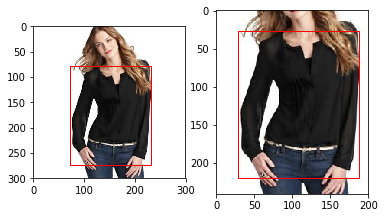

In [32]:
cropToBBox(sourceImgPath,targetImgPath,*bbox_dict[testKey],showResult=True)

In [33]:
# create folders with all files
bbox_crop_dict = {}
trainPartition_crop = []
for sImgKey in trainPartition:
    sourceImgPath = sImgKey.replace('img/',sourceDir)
    targetImgPath = sImgKey.replace('img/',targetDir)
    tDir = os.path.dirname(targetImgPath)
    if not os.path.exists(tDir): os.mkdir(tDir)
    try:
        bbox_crop_dict[sImgKey] = cropToBBox(sourceImgPath,targetImgPath,*bbox_dict[testKey],showResult=False)
        trainPartition_crop.append(sImgKey)
    except:
        pass
    

In [35]:
len(trainPartition_crop)

249105

In [38]:
with open(os.path.join(targetDir.replace('Img','Anno'),'cropped_list_clothing_bbox_class.txt'),'w') as fp:
    startPath = targetDir
    for imgk in trainPartition_crop:
        cl_class = imgk.split('/')[1].split('_')[-1]
        arg1 = imgk.replace('img/',startPath)
        arg2 = ','.join(map(str,bbox_crop_dict[imgk]))
        arg3 = mainCatagories[cl_class]
        fp.write(arg1 + ',' + arg2 + ','+ arg3 + '\n')

In [37]:
targetDir

'../dataCropBB/Img/'